In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
import seaborn as sns
from scipy.stats import wilcoxon, norm

generated_guis_path = '../generated_guis'
prompts = ["instruction", "pd_zs", "pd_fs", "ref_instruction"]
metrics = ['nonresponsive', 'overlap', 'boundary', "dimensions", "description", "spacing", "color", "focus", "labels", "errors"]

app_ids = [name for name in os.listdir(generated_guis_path) if os.path.isdir(os.path.join(generated_guis_path, name))]

### Prikaz in primerjava vseh metrik

In [37]:
df1 = pd.read_csv('./design_evaluation/dimensions_activeness_overlap.csv', delimiter=';')
df2 = pd.read_csv('./description_validation/description_validation.csv', delimiter=';')
df3 = pd.read_csv('./alignment_color_focus.csv', delimiter=',')
df4 = pd.read_csv('./console_errors.csv', delimiter=';')

df_new = pd.DataFrame()
df_new['app_id'] = df1['app_id']
df_new['prompt'] = df1['prompt']
df_new['nonresponsive'] = 1 - (df1['nonresponsive'] / df1['all'])
df_new['overlap'] = 1 - (df1['overlap'] / df1['all'])
df_new['boundary'] = 1 - (df1['boundary'] / df1['all'])
df_new['dimensions'] = 1 - df1['dimensions']
df_new['description'] = df2['correct'] / df2['all']
df_new['spacing'] = df3['spacing_md']
df_new['color'] = df3['color_contrast']
df_new['focus'] = df3['focusable_ratio']
df_new['labels'] = df3['labelled_ratio']
df_new['errors'] = 1 - df4['errors'] / df4['errors'].max()

In [5]:
OUT_DIR = Path("prompt_plots")
OUT_DIR.mkdir(exist_ok=True)

metric_vector = df_new.groupby("prompt")[metrics].mean().reset_index()
metric_vector["mean_score"] = metric_vector[metrics].mean(axis=1)

display(metric_vector.sort_values("mean_score", ascending=False).head(10))

,prompt,nonresponsive,overlap,boundary,dimensions,description,spacing,color,focus,labels,errors,mean_score
0,instruction,0.790814,0.971970,0.985985,0.931818,0.962011,0.446919,0.368074,1.000000,0.097222,0.967532,0.752234
3,ref_instruction,0.665765,0.956420,0.950180,0.909091,0.886594,0.561097,0.384271,0.953328,0.262029,0.958874,0.748765
1,pd_fs,0.578681,0.948232,0.978365,0.977273,0.847239,0.432709,0.554993,1.000000,0.082011,0.957792,0.735730
2,pd_zs,0.658865,0.952324,0.971812,0.863636,0.841251,0.465146,0.323665,0.964103,0.109992,0.941558,0.709235


In [147]:
def highlight_best_latex(df, metric_cols):
    df_formatted = df.copy()
    for col in metric_cols:
        max_val = df[col].max()
        df_formatted[col] = df[col].apply(
            lambda x: f"\\textbf{{\\underline{{{x:.3f}}}}}" if x == max_val else f"{x:.3f}"
        )
    return df_formatted

df_fmt = highlight_best_latex(metric_vector, metrics)

latex_table1 = df_fmt[["prompt", 'nonresponsive', 'overlap', 'boundary', "dimensions"]].to_latex(
    index=False,
    escape=False,
    caption="Ocena odzivnosti in prekrivanja elementov, seganja elementov čez rob vmesnika ter ustreznosti dimenzij generiranih GUI",
    label="tab:obj_metric_manual",
    column_format="lrrrrrrrrr",
)
latex_table2 = df_fmt[["prompt", "spacing", "color", "focus", "labels", "errors"]].to_latex(
    index=False,
    escape=False,
    caption="Ocena razmakov med elementi, barvnega kontrasta, ustreznosti label in količine napak v konzoli pri generiranih GUI",
    label="tab:obj_metric_auto",
    column_format="lrrrrrrrrr",
)
print(latex_table1)
print(latex_table2)

\begin{table}
\caption{Ocena odzivnosti in prekrivanja elementov, seganja elementov čez rob vmesnika ter ustreznosti dimenzij generiranih GUI}
\label{tab:obj_metric_manual}
\begin{tabular}{lrrrrrrrrr}
\toprule
prompt & nonresponsive & overlap & boundary & dimensions \\
\midrule
instruction & \textbf{\underline{0.791}} & \textbf{\underline{0.972}} & \textbf{\underline{0.986}} & 0.932 \\
pd_fs & 0.579 & 0.948 & 0.978 & \textbf{\underline{0.977}} \\
pd_zs & 0.659 & 0.952 & 0.972 & 0.864 \\
ref_instruction & 0.666 & 0.956 & 0.950 & 0.909 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Ocena razmakov med elementi, barvnega kontrasta, ustreznosti label in količine napak v konzoli pri generiranih GUI}
\label{tab:obj_metric_auto}
\begin{tabular}{lrrrrrrrrr}
\toprule
prompt & spacing & color & focus & labels & errors \\
\midrule
instruction & 0.447 & 0.368 & \textbf{\underline{1.000}} & 0.097 & \textbf{\underline{0.968}} \\
pd_fs & 0.433 & \textbf{\underline{0.555}} & \textbf{\

### Primerjava skladnosti z zahtevami: Wilksonov test

In [35]:
def wilcoxon_pairwise(df, metric_col='description', method_col='prompt', alpha=0.05):
    """
    Izvede Wilcoxon signed-rank test med vsemi pari metod.
    Vrne DataFrame z:
        - par metod
        - p-vrednost
        - efekt velikosti (r)
        - interpretacijo (significant / not)
    """
    results = []

    methods = df[method_col].unique()
    pairs = list(itertools.combinations(methods, 2))

    for m1, m2 in pairs:
        # Filtriraj podatke za oba
        d1 = df[df[method_col] == m1][metric_col].values
        d2 = df[df[method_col] == m2][metric_col].values

        # morata imeti enako dolžino in iste primere (če imaš ID GUI)
        n = min(len(d1), len(d2))
        d1 = d1[:n]
        d2 = d2[:n]

        # Wilcoxon test
        stat, p = wilcoxon(d1, d2, zero_method='wilcox', correction=False, alternative='two-sided')

        # približek Z vrednosti iz statistike W (Wilcoxon T)
        # mean(W) = n(n+1)/4, std(W) = sqrt(n(n+1)(2n+1)/24)
        mean_w = n * (n + 1) / 4
        std_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
        z = (stat - mean_w) / std_w

        # efekt velikosti
        r = abs(z) / np.sqrt(n)

        results.append({
            'method_1': m1,
            'method_2': m2,
            'p_value': p,
            'effect_size_r': r,
            'significant': 'YES' if p < alpha else 'NO'
        })

    return pd.DataFrame(results).sort_values('p_value')


In [38]:
results = wilcoxon_pairwise(df_new, metric_col='description', method_col='prompt')
print(results.to_latex())

\begin{tabular}{lllrrl}
\toprule
 & method_1 & method_2 & p_value & effect_size_r & significant \\
\midrule
1 & instruction & pd_fs & 0.000032 & 0.868238 & YES \\
0 & instruction & pd_zs & 0.000138 & 0.833931 & YES \\
2 & instruction & ref_instruction & 0.002377 & 0.812819 & YES \\
4 & pd_zs & ref_instruction & 0.109425 & 0.655357 & NO \\
5 & pd_fs & ref_instruction & 0.184092 & 0.761798 & NO \\
3 & pd_zs & pd_fs & 0.875798 & 0.549796 & NO \\
\bottomrule
\end{tabular}



### Primerjava generiranih elementov

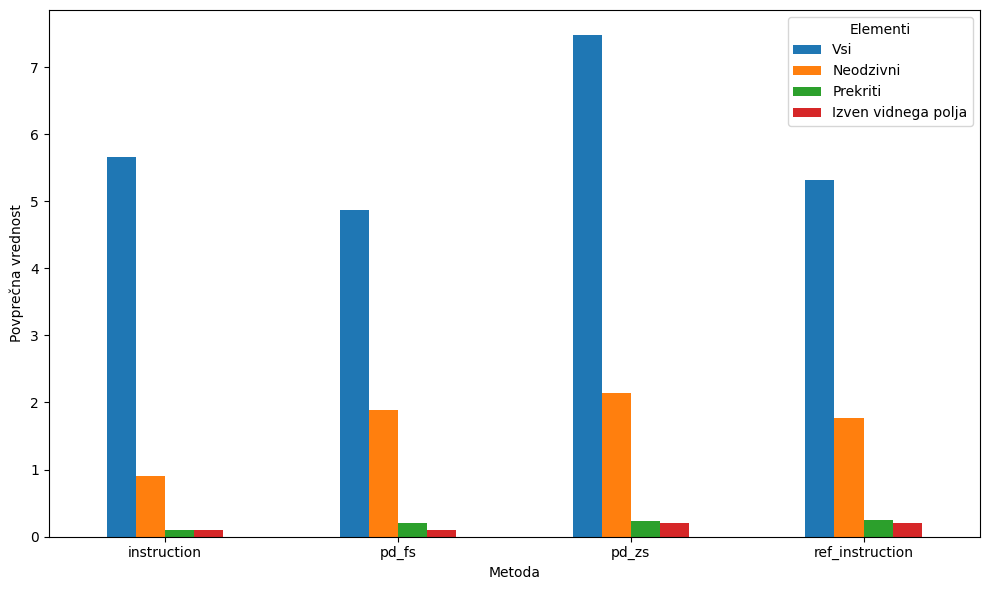

\begin{tabular}{lrrr}
\toprule
 & nonresponsive_pct & overlap_pct & boundary_pct \\
prompt &  &  &  \\
\midrule
instruction & 0.790814 & 0.971970 & 0.985985 \\
pd_fs & 0.578681 & 0.948232 & 0.978365 \\
pd_zs & 0.658865 & 0.952324 & 0.971812 \\
ref_instruction & 0.665765 & 0.956420 & 0.950180 \\
\bottomrule
\end{tabular}



In [30]:
df1 = pd.read_csv('./design_evaluation/dimensions_activeness_overlap.csv', delimiter=';')

df_elements = pd.DataFrame()
df_elements['app_id'] = df1['app_id']
df_elements['prompt'] = df1['prompt']
df_elements['Neodzivni'] = df1['nonresponsive']
df_elements['Prekriti'] = df1['overlap']
df_elements['Izven vidnega polja'] = df1['boundary']
df_elements['Vsi'] = df1['all']
df_elements['nonresponsive_pct'] = 1 - (df1['nonresponsive'] / df1['all'])
df_elements['overlap_pct'] = 1 - (df1['overlap'] / df1['all'])
df_elements['boundary_pct'] = 1 - (df1['boundary'] / df1['all'])
df_elements['all_pct'] = df1['all'] / df1['all'].max()

avg_df = df_elements.groupby('prompt')[['Vsi', 'Neodzivni', 'Prekriti', 'Izven vidnega polja']].mean()

In [ ]:
avg_df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Povprečna vrednost')
plt.xlabel('Metoda')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Elementi')
plt.tight_layout()
plt.savefig(OUT_DIR / "elements.png")
plt.show()

In [ ]:
pct_df = df_elements.groupby('prompt')[['nonresponsive_pct', 'overlap_pct', 'boundary_pct']].mean()
print(pct_df.to_latex())

In [33]:
results = wilcoxon_pairwise(df_elements, metric_col='Vsi', method_col='prompt')
print(results.to_latex())

\begin{tabular}{lllrrl}
\toprule
 & method_1 & method_2 & p_value & effect_size_r & significant \\
\midrule
3 & pd_zs & pd_fs & 0.000050 & 0.782910 & YES \\
0 & instruction & pd_zs & 0.001549 & 0.726611 & YES \\
4 & pd_zs & ref_instruction & 0.001966 & 0.762677 & YES \\
5 & pd_fs & ref_instruction & 0.037821 & 0.731009 & YES \\
1 & instruction & pd_fs & 0.059261 & 0.760918 & NO \\
2 & instruction & ref_instruction & 0.765641 & 0.664154 & NO \\
\bottomrule
\end{tabular}



### P@k, AvP@k, MRR, HITS@k, DCG@k, NDCG@k

In [137]:
# ---------- 1. Binarizacija relevanc ----------
def binarize_relevance(relevance_list, threshold=1):
    """
    Vse vrednosti >= threshold postavi na 1, ostalo na 0.
    """
    return [1 if r >= threshold else 0 for r in relevance_list]

# ---------- 2. Precision@k ----------
def precision_at_k(relevance_list, k):
    relevance_list = np.asarray(relevance_list)[:k]
    if len(relevance_list) == 0:
        return 0.0
    print("precision_at_k:", np.sum(relevance_list), len(relevance_list), relevance_list)
    return np.sum(relevance_list) / len(relevance_list)

# ---------- 3. Average Precision ----------
def average_precision(relevance_list):
    relevance_list = np.asarray(relevance_list)
    relevant_indices = np.where(relevance_list == 1)[0]
    if len(relevant_indices) == 0:
        return 0.0
    precisions = [(i+1)/(idx+1) for i, idx in enumerate(relevant_indices)]
    return np.mean(precisions)

# ---------- 4. Mean Reciprocal Rank ----------
def mean_reciprocal_rank(list_of_relevance_lists):
    rr_total = 0.0
    for relevances in list_of_relevance_lists:
        for idx, val in enumerate(relevances, start=1):
            if val:
                rr_total += 1.0 / idx
                break
    return rr_total / len(list_of_relevance_lists)

# ---------- 5. HITS@k ----------
def hits_at_k(relevance_list, k):
    return 1.0 if np.sum(relevance_list[:k]) > 0 else 0.0

# ---------- 6. DCG@k ----------
def dcg_at_k(relevance_list, k):
    relevance_list = np.asarray(relevance_list)[:k]
    return np.sum((2**relevance_list - 1) / np.log2(np.arange(2, len(relevance_list)+2)))

# ---------- 7. NDCG@k ----------
def ndcg_at_k(relevance_list, k):
    dcg = dcg_at_k(relevance_list, k)
    idcg = dcg_at_k(sorted(relevance_list, reverse=True), k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

# ---------- 8. Funkcija za celoten DataFrame ----------
def evaluate_gui_ir_metrics(df, k=10, rel_col='description', group_col='prompt'):
    """
    df: DataFrame z stolpci group_col (metoda) in rel_col (relevance score 0/1/2)
    k: top-k za Precision@k, DCG@k, NDCG@k, HITS@k
    """
    results = {}
    for method in df[group_col].unique():
        df_m = df[df[group_col] == method].copy()
        # predpostavimo, da imamo po query GUI-je rangirane v stolpcu app_id
        # zberemo relevance po query
        grouped = df_m.groupby('app_id')[rel_col].apply(list).tolist()

        # binarna relevanca za metrike, kjer je to potrebno
        binary_lists = [binarize_relevance(lst) for lst in grouped]
        print(method, binary_lists)

        # Precision@k, AvgP, MRR, HITS@k
        precision_list = [precision_at_k(lst, k) for lst in binary_lists]
        avgp_list = [average_precision(lst) for lst in binary_lists]
        hits_list = [hits_at_k(lst, k) for lst in binary_lists]
        mrr = mean_reciprocal_rank(binary_lists)

        # DCG@k in NDCG@k (upošteva tudi R=1)
        dcg_list = [dcg_at_k(lst, k) for lst in grouped]
        ndcg_list = [ndcg_at_k(lst, k) for lst in grouped]

        results[method] = {
            'Precision@k': np.mean(precision_list),
            'AvgP': np.mean(avgp_list),
            'MRR': mrr,
            'HITS@k': np.mean(hits_list),
            'DCG@k': np.mean(dcg_list),
            'NDCG@k': np.mean(ndcg_list)
        }
    return results

instruction [[0], [1], [1], [0], [0], [1], [1], [1], [1], [1], [0], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [0], [1], [1], [1], [1], [1], [1], [1], [0], [1], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [1]]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 0 1 [0]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 0 1 [0]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 0 1 [0]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 0 1 [0]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 1 1 [1]
precision_at_k: 0 1 [0]
precision_at_k: 1 1 [1]

In [ ]:
metrics = evaluate_gui_ir_metrics(df_new, k=10, rel_col='description', group_col='prompt')
print(metrics)